<a href="https://colab.research.google.com/github/erfury/Castle_in_the_sky/blob/main/Castel_In_the_sky.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Castle in the Sky: Dynamic Sky Replacement and Harmonization in Videos**

##**Introduction**

A vision-based method for video sky replacement and harmonization, which can automatically generate realistic and dramatic sky backgrounds in videos with controllable styles. Different from previous sky editing methods that either focus on static photos or require inertial measurement units integrated in smartphones on shooting videos, the method is purely vision-based, without any requirements on the capturing devices, and can be well applied to either **online** or **offline** processing scenarios. This method runs in real-time and is free of user interactions. We decompose this artistic creation process into a couple of proxy tasks including **sky matting, motion estimation,** and **image blending**. Experiments are conducted on videos diversely captured in the wild by handheld smartphones and dash cameras, and show high fidelity and good generalization of this method in both visual quality and lighting/motion dynamics.

**# Contributions**

This notebook provides an minimal working example of the sky augmentation in the preprint paper "Castle in the Sky: Dynamic Sky Replacement and Harmonization in Videos"


1.  **Author**= Zhengxia Zou 
2. **Year**=2020
2.  **Journal**=arXiv preprint arXiv:2010.11800

[Project Page](https://jiupinjia.github.io/skyar/) | [GitHub](https://github.com/jiupinjia/SkyAR) | [Preprint](https://arxiv.org/abs/2010.11800)

**Here we are cloning the repository**

In [33]:
# Clone the repository
!git clone https://github.com/jiupinjia/SkyAR.git 

Cloning into 'SkyAR'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 161 (delta 29), reused 6 (delta 2), pack-reused 103
Receiving objects: 100% (161/161), 71.07 MiB | 48.13 MiB/s, done.
Resolving deltas: 100% (68/68), done.


In [34]:
cd SkyAR

/content/SkyAR/SkyAR/SkyAR


**Importing the important libraries**

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import glob
import argparse
from networks import *
from skyboxengine import *
import utils
import torch

%matplotlib inline

# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**Download pretrained sky matting model**

In [36]:
# Define some helper functions for downloading pretrained model
# taken from this StackOverflow answer: https://stackoverflow.com/a/39225039
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [37]:
# download and unzip...
file_id = '1COMROzwR4R_7mym6DL9LXhHQlJmJaV0J'
destination = './checkpoints_G_coord_resnet50.zip'
download_file_from_google_drive(file_id, destination)

In [38]:
!unzip checkpoints_G_coord_resnet50.zip

Archive:  checkpoints_G_coord_resnet50.zip
   creating: checkpoints_G_coord_resnet50/
  inflating: checkpoints_G_coord_resnet50/best_ckpt.pt  


**Configuring the Model**

In [39]:
parser = argparse.ArgumentParser(description='SKYAR')
args = utils.parse_config(path_to_json='./config/config-canyon-jupiter.json')

***config the following if you would like to see a different stlyle***

In [40]:
#config the following if you would like to see a different stlyle

# args.net_G = "coord_resnet50"
# args.ckptdir = "./checkpoints_G_coord_resnet50"

# args.datadir = "./test_videos/canyon.mp4" # choose a foreground video
# args.skybox = "floatingcastle.jpg" # choose a skybox template

# args.in_size_w = 384 # input size to sky matting model
# args.in_size_h = 384 # ...
# args.out_size_w = 845 # output video resolution
# args.out_size_h = 480 # ...

# args.skybox_center_crop = 0.5 # view of the virtual camera
# args.auto_light_matching = False 
# args.relighting_factor = 0.8
# args.recoloring_factor = 0.5
# args.halo_effect = True

**Defining some helper functions of the skyfilter**

In [41]:
class SkyFilter():

    def __init__(self, args):

        self.ckptdir = args.ckptdir
        self.datadir = args.datadir
        self.input_mode = args.input_mode

        self.in_size_w, self.in_size_h = args.in_size_w, args.in_size_h
        self.out_size_w, self.out_size_h = args.out_size_w, args.out_size_h

        self.skyboxengine = SkyBox(args)

        self.net_G = define_G(input_nc=3, output_nc=1, ngf=64, netG=args.net_G).to(device)
        self.load_model()

        self.video_writer = cv2.VideoWriter('demo.avi', cv2.VideoWriter_fourcc(*'MJPG'),
                                            20.0, (args.out_size_w, args.out_size_h))
        self.video_writer_cat = cv2.VideoWriter('demo-cat.avi', cv2.VideoWriter_fourcc(*'MJPG'),
                                            20.0, (2*args.out_size_w, args.out_size_h))

        if os.path.exists(args.output_dir) is False:
            os.mkdir(args.output_dir)

        self.output_img_list = []

        self.save_jpgs = args.save_jpgs


    def load_model(self):
        # load pretrained sky matting model
        print('loading the best checkpoint...')
        checkpoint = torch.load(os.path.join(self.ckptdir, 'best_ckpt.pt'))
        self.net_G.load_state_dict(checkpoint['model_G_state_dict'])
        self.net_G.to(device)
        self.net_G.eval()


    def write_video(self, img_HD, syneth):

        frame = np.array(255.0 * syneth[:, :, ::-1], dtype=np.uint8)
        self.video_writer.write(frame)

        frame_cat = np.concatenate([img_HD, syneth], axis=1)
        frame_cat = np.array(255.0 * frame_cat[:, :, ::-1], dtype=np.uint8)
        self.video_writer_cat.write(frame_cat)

        # define a result buffer
        self.output_img_list.append(frame_cat)
        

    def synthesize(self, img_HD, img_HD_prev):

        h, w, c = img_HD.shape

        img = cv2.resize(img_HD, (self.in_size_w, self.in_size_h))

        img = np.array(img, dtype=np.float32)
        img = torch.tensor(img).permute([2, 0, 1]).unsqueeze(0)

        with torch.no_grad():
            G_pred = self.net_G(img.to(device))
            G_pred = torch.nn.functional.interpolate(G_pred, (h, w), mode='bicubic', align_corners=False)
            G_pred = G_pred[0, :].permute([1, 2, 0])
            G_pred = torch.cat([G_pred, G_pred, G_pred], dim=-1)
            G_pred = np.array(G_pred.detach().cpu())
            G_pred = np.clip(G_pred, a_max=1.0, a_min=0.0)

        skymask = self.skyboxengine.skymask_refinement(G_pred, img_HD)

        syneth = self.skyboxengine.skyblend(img_HD, img_HD_prev, skymask)

        return syneth, G_pred, skymask



    def cvtcolor_and_resize(self, img_HD):

        img_HD = cv2.cvtColor(img_HD, cv2.COLOR_BGR2RGB)
        img_HD = np.array(img_HD / 255., dtype=np.float32)
        img_HD = cv2.resize(img_HD, (self.out_size_w, self.out_size_h))

        return img_HD
        

    def process_video(self):

        # process the video frame-by-frame

        cap = cv2.VideoCapture(self.datadir)
        m_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        img_HD_prev = None
        
        for idx in range(m_frames):
            ret, frame = cap.read()
            if ret:
                img_HD = self.cvtcolor_and_resize(frame)

                if img_HD_prev is None:
                    img_HD_prev = img_HD

                syneth, G_pred, skymask = self.synthesize(img_HD, img_HD_prev)

                self.write_video(img_HD, syneth)

                img_HD_prev = img_HD

                if idx % 50 == 1:
                  print('processing video, frame %d / %d ... ' % (idx, m_frames))

            else:  # if reach the last frame
                break


**Now we can process your video**

In [42]:
sf = SkyFilter(args)
sf.process_video()

initialize skybox...
initialize network with normal
loading the best checkpoint...
processing video, frame 1 / 888 ... 
processing video, frame 51 / 888 ... 
processing video, frame 101 / 888 ... 
processing video, frame 151 / 888 ... 
processing video, frame 201 / 888 ... 
processing video, frame 251 / 888 ... 
processing video, frame 301 / 888 ... 
processing video, frame 351 / 888 ... 
processing video, frame 401 / 888 ... 
processing video, frame 451 / 888 ... 
processing video, frame 501 / 888 ... 
processing video, frame 551 / 888 ... 
processing video, frame 601 / 888 ... 
processing video, frame 651 / 888 ... 
processing video, frame 701 / 888 ... 
processing video, frame 751 / 888 ... 
processing video, frame 801 / 888 ... 
processing video, frame 851 / 888 ... 


### **Check out the  RESULTS and few Video Example**

Look for the full Maximization of the result and you can **loop** it

1.   For the full view of the Video you can also download it from the directory




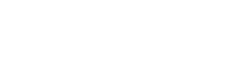

In [43]:
# Check out your results at './SkyAR/demo.avi' and './SkyAR/demo-cat.avi'. 
# Download them and enjoy.

# If you would like to pre-view your results. Run the following to see the animated 
# results of the first 40 frames.

import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(4,8))
plt.axis('off')
ims = [[plt.imshow(img[:,:,::-1], animated=True)] for img in sf.output_img_list[0:40]]
ani = animation.ArtistAnimation(fig, ims, interval=50)

HTML(ani.to_jshtml())

**One More Example**

Configuring the model for supermoon example

In [44]:
parser = argparse.ArgumentParser(description='SKYAR')
args = utils.parse_config(path_to_json='./config/config-annarbor-supermoon.json')

Processing the video

In [45]:
sf = SkyFilter(args)
sf.process_video()

initialize skybox...
initialize network with normal
loading the best checkpoint...
processing video, frame 1 / 206 ... 
processing video, frame 51 / 206 ... 
processing video, frame 101 / 206 ... 
processing video, frame 151 / 206 ... 
processing video, frame 201 / 206 ... 


Plotting the results

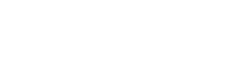

In [46]:
# Check out your results at './SkyAR/demo.avi' and './SkyAR/demo-cat.avi'. 
# Download them and enjoy.

# If you would like to pre-view your results. Run the following to see the animated 
# results of the first 40 frames.

import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(4,8))
plt.axis('off')
ims = [[plt.imshow(img[:,:,::-1], animated=True)] for img in sf.output_img_list[0:40]]
ani = animation.ArtistAnimation(fig, ims, interval=50)

HTML(ani.to_jshtml())

# **THANK YOU!     I HOPE YOU ENJOYED THE VIDEO**